# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [6]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [7]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [8]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.001901 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `../data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [9]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in ['node', 'line', 'source', 'sym_load']:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'../data/{component}.csv')

        # Initialize array
        input_data[component] = initialize_array('input', component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


node     : 2001
line     : 2000
source   :    1
sym_load : 2000
Execution time for Loading Input Data is 0.012917 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/alliander-opensource/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [16]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.077347 s


ValidationException: There is a validation error in input_data:
	Field 'type' contains invalid LoadGenType values for 2000 sym_loads.

# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [11]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.000957 s
{'line': 2000, 'node': 2001, 'source': 1, 'sym_load': 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [12]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.001744 s
Min line loading: 0.14188449783808707
Max line loading: 1.6292378285645808


In [13]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Linear Power Flow is 0.003713 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [ ]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 1e4 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="H")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,9.846573e+05,1.036605e+06,926319.273681,981037.237437,1.081915e+06,891679.022654,933634.513455,1.050234e+06,1.029867e+06,9.941968e+05,...,1.012391e+06,1.061862e+06,1.046040e+06,934512.470263,926662.380752,1.005303e+06,937803.739343,1.094178e+06,928165.556148,1.080244e+06
2022-01-01 01:00:00,1.003852e+06,1.046497e+06,911004.394025,976072.883535,1.080340e+06,903242.946004,929745.960818,1.054085e+06,1.030168e+06,1.012888e+06,...,1.011006e+06,1.082059e+06,1.080289e+06,932421.538137,891420.002876,9.912526e+05,940781.673787,1.086227e+06,918875.300938,1.069453e+06
2022-01-01 02:00:00,9.889423e+05,1.029289e+06,913662.826062,979814.258051,1.064715e+06,906797.668620,912858.322443,1.064064e+06,1.021966e+06,1.011320e+06,...,9.892356e+05,1.075767e+06,1.064086e+06,924338.157273,931906.589500,9.918518e+05,930337.197820,1.086183e+06,926790.672433,1.073818e+06
2022-01-01 03:00:00,9.985392e+05,1.064795e+06,931862.018042,959657.545291,1.061387e+06,891311.584876,938308.232916,1.048784e+06,1.018019e+06,1.005237e+06,...,9.949064e+05,1.078005e+06,1.053301e+06,935440.262119,901429.205034,9.975361e+05,941952.962860,1.095023e+06,927261.207776,1.085163e+06
2022-01-01 04:00:00,9.829544e+05,1.050185e+06,902681.193087,950611.702717,1.092845e+06,905544.644966,935318.344857,1.053763e+06,1.018240e+06,1.022415e+06,...,1.009909e+06,1.072374e+06,1.051744e+06,932667.237875,912104.263275,9.846007e+05,952979.949104,1.077156e+06,916339.911943,1.090441e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,9.783088e+05,1.038971e+06,910230.104394,962323.621183,1.077958e+06,893538.331231,914885.741977,1.061741e+06,1.024646e+06,1.004903e+06,...,9.780563e+05,1.061903e+06,1.047855e+06,922818.633512,921704.522710,9.937841e+05,961652.090497,1.076507e+06,922319.161840,1.087462e+06
2022-02-11 12:00:00,9.946695e+05,1.023456e+06,917268.230516,973139.448835,1.060700e+06,911829.094471,927143.099646,1.058329e+06,1.015586e+06,1.022188e+06,...,1.002707e+06,1.088517e+06,1.061988e+06,919548.459336,897806.068555,9.616835e+05,931345.905476,1.097180e+06,939144.713827,1.103556e+06
2022-02-11 13:00:00,9.858844e+05,1.023175e+06,914621.559463,957316.136099,1.087083e+06,908461.133282,924108.663685,1.044666e+06,1.022974e+06,1.015319e+06,...,1.002170e+06,1.074151e+06,1.056402e+06,914651.751236,907127.959625,9.848536e+05,931512.802749,1.088983e+06,924357.512909,1.101208e+06
2022-02-11 14:00:00,1.009425e+06,1.038739e+06,904001.005941,977794.820184,1.088567e+06,892677.593246,936648.878609,1.053450e+06,1.033599e+06,1.032438e+06,...,9.988844e+05,1.071108e+06,1.042708e+06,926959.669400,895689.147956,9.878928e+05,935607.041158,1.082467e+06,917125.232565,1.073960e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [ ]:
# Initialize an empty load profile
load_profile = initialize_array("update", "sym_load", df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {"sym_load": load_profile}

In [ ]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 4.943465 s


In [ ]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 4.874295 s


In [ ]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.725211 s


## Plotting batch results

Lets say we wish to plot the loading of the `line 7` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

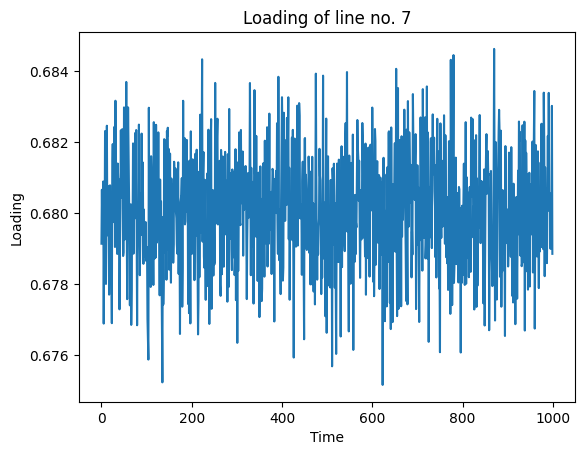

In [ ]:
result_loading = output_data["line"]["loading"][:,6]
plt.plot(result_loading)
plt.title('Loading of line no. 7')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line 7` is greater than `68.4%`

In [ ]:
ind = np.where(result_loading > 0.684)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-10 07:00:00', '2022-01-28 05:00:00',
               '2022-02-02 06:00:00', '2022-02-02 12:00:00',
               '2022-02-06 06:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [ ]:
n_lines = len(input_data["line"])

# Initialize an empty line profile
line_profile = initialize_array("update", "line", (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data["line"]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {"line": line_profile}

In [ ]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 7.174446 s


In [ ]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 10.875645 s


In [ ]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 2.877830 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [ ]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 10.054219 s
Execution time for Single thread is 10.974926 s
Execution time for Two threads in parallel is 4.952455 s
Execution time for Four threads in parallel is 3.028397 s
Execution time for Use number of threads based the machine hardware is 2.060880 s
